<a href="https://colab.research.google.com/github/lcaspari/42_tensorflow_homework/blob/main/final_project/Disentangled_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
from tensorflow import math as tfm

In [ ]:
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()

In [ ]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)


In [ ]:
train_size = 60000
batch_size = 32
test_size = 10000

In [ ]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

## Define Encoder

In [ ]:

class Encoder(tf.keras.layers.Layer):
  def __init__(self, latent_dim):
    super(Encoder, self).__init__()

    self.latent_dim = latent_dim
    self.conv1 = tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation='relu'
    )

    self.conv2 = tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation='relu'
    )

    self.flatten = tf.keras.layers.Flatten()
    self.mu = tf.keras.layers.Dense(self.latent_dim)
    self.sig = tf.keras.layers.Dense(self.latent_dim, activation="relu")

  def call(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.flatten(x)
    
    mu = self.mu(x)
    sig = self.sig(x)

    return mu, sig

## Define Decoder

In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self):
    super(Decoder, self).__init__()
    
    self.inLayer = tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu)
    
    self.shape = tf.keras.layers.Reshape(target_shape=(7, 7, 32))
    
    self.convT1 = tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=2, 
        padding='same', activation='relu'
    )
    
    self.convT2 = tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=2, 
        padding='same', activation='relu'
    )
    
    self.convT3 = tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=1, padding='same'
    )
  
  def call(self, x):
    x = self.inLayer(x)
    x = self.shape(x)
    x = self.convT1(x)
    x = self.convT2(x)
    x = self.convT3(x)

    return x

In [ ]:
# input shape of encoder is 28x28x1
test = train_dataset.take(1)
print(test)

<TakeDataset shapes: (None, 28, 28, 1), types: tf.float32>


# Define the Model

In [ ]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim, beta=1):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.beta = beta

    self.encoder = Encoder(latent_dim=self.latent_dim)
    self.decoder = Decoder()

    self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
    self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
        name = "reconstruction_loss"
    )
    self.kl_loss_tracker = tf.keras.metrics.Mean(name = "kl_loss")
    
  @property
  def metrics(self):
    return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker
    ]

  @staticmethod
  def _data_fidelity_loss(x, x_hat, eps=1e-10):
    """
    Params:
      (Tensor) X:
          The original input data that was passed to the VAE.
          (N, C, H, W)

      (Tensor) X_hat  
          The reconstructed data, the output of the VAE.
          (N, C, H, W)
      
      (Double) eps:    
          A small positive double used to ensure we don't get log of 0.
    
    Retuns  
      (Tensor):
          A tensor containing the Data Fidelity term of the loss function,
          which is given by the formula below.

          E_{z ~ q_{phi}(z | x)}[log(p_{theta}(x|z))] 
          = sum(x * log(x_hat) + (1 - x) * log(1 - x_hat))
       
    """

    data_fidelity = tfm.reduce_sum(
        x * tfm.log(eps + x_hat) + (1 - x) * tfm.log(eps + 1 - x_hat),
        axis=[1,2,3],
    )

    return data_fidelity

  @staticmethod
  def _kl_divergence_loss(mean, std):
    """
    :param Tensor mean:  The output of the mean layer, computed with the output of the
                            encoder. (N, z_dim)
    :param Tensor std:   The output of the standard deviation layer, computed with the output
                            of the encoder. (N, z_dim)
    :return:  A tensor consisting of the KL-Divergence term of the loss function, which is
                given by the formula below.
    :rtype:   Tensor
    D_{KL}[q_{phi}(z | x) || p_{theta}(x)] = (1/2) * sum(std + mean^2 - 1 - log(std))
        In the above equation we substitute std with e^{std} to improve numerical stability.
    This method computes the KL-Divergence term of the loss function. It substitutes the
    value of the standard deviation layer with exp(standard deviation) in order to ensure
    numerical stability.
    """

    # compute the kl divergence for each training example and return it
    kl_divergence = (1 / 2) * tfm.reduce_sum(
        tfm.exp(std) + tfm.square(mean) - 1 - std, 
        axis=1
    )

    return kl_divergence

  @staticmethod
  def criterion(x, x_hat, mean, std):
    """
     This method computes the loss of the B-VAE using the formula:
        
        L(x, x_hat) = - E_{z ~ q_{phi}(z | x)}[log(p_{theta}(x|z))]
                      + beta * D_{KL}[q_{phi}(z | x) || p_{theta}(x)]

    Params:
      (tensor) x: 
          The original input data passed trough the b-VAE
          (Batch, H, W)

      (tensor) x_hat:
          the prediction from the b-VAE
          (Batch, H, W)

    Returns:
      (dict) losses
    """ 

    fidelity_loss =  _data_fidelity_loss(x, x_hat)
    kl_loss       =  _kl_divergence_loss(mean, std)

    loss = -data_fidelity_loss + self.beta * kl_divergence_loss

    losses = {
        "data_fidelity": tf.math.reduce_mean(fidelity_loss),
        "kl_divergence": tf.math.reduce_mean(kl_divergence_loss),
        "beta_kl_divergence": self.beta * tf.math.reduce_mean(kl_loss),
        "loss": tf.math.reduce_mean(loss)
    }    

    return losses

  @tf.function
  def sample(self, epsilon=None):
    if epsilon is None:
      epsilon = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(epsilon, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = self.encoder(x)
    return mean, logvar

  def reparameterize(self, mean, std):
    epsilon = tf.random.normal(shape=mean.shape)
    return mean + epsilon * (1.0 / 2) * std

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits



# Compute the loss

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def data_fidelity(x, x_hat, mean, std, eps=1e-10):
  """
  Calcultes the data fidelity loss with this formular:


  E_{z ~ q_{phi}(z | x)}[log(p_{theta}(x|z))] 
  = sum(x * log(x_hat) + (1 - x) * log(1 - x_hat))
  
    which is basically a Cross Entropy Loss.
    https://en.wikipedia.org/wiki/Cross_entropy
  """

  p1 = x * tf.math.log(eps + x_hat)
  p2 = (1 - x) * tf.math.log(eps + 1 - x_hat)

  try:
    if np.any(tf.math.is_nan(p1).numpy()):
      print("p1 is faulty")
  
    if np.any(tf.math.is_nan(tf.math.log(testVals)).numpy()):
      print("p2 is fualty")
  except:
    pass

  data_fidelity = tf.reduce_sum(
      p1 + p2,
      axis=[1,2]
  )

  return data_fidelity

def kl_divergence_loss(mean, std):
  
  kl_divergence = (1 / 2) * tf.reduce_sum(tf.math.exp(std) + tf.math.square(mean) - 1 - std, axis=1)
  
  return kl_divergence

def compute_loss(model, x, beta = 4):
  # get the mean and sigma from the model
  mean, std = model.encode(x)

  # get a value by reparametrizing with mean and logvar from the network
  z = model.reparameterize(mean, std)

  # Running the latent vector trough the decoder will yield the decoded(/generated) image 
  x_hat = model.decode(z)

  #fidelity_loss = data_fidelity(x, x_hat, mean, std)
  fidelity_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_hat, labels=x)
  fidelity_loss = -tf.reduce_sum(fidelity_loss, axis=[1, 2, 3])

  kl_divergence = kl_divergence_loss(mean, std)

  loss = -fidelity_loss + beta * kl_divergence

  if tf.math.is_nan(loss) is False:
    raise TypeError("Loss nan")
  
  return loss


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))


In [ ]:
epochs = 30
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 10
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)


In [ ]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


In [ ]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]


Epoch: 30, Test set ELBO: -108.47460174560547, time elapse for current epoch: 8.797649621963501


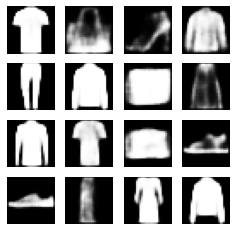

In [ ]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)


(-0.5, 287.5, 287.5, -0.5)

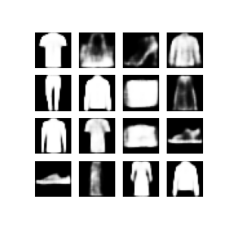

In [ ]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

plt.imshow(display_image(epoch))
plt.axis('off')  # Display images


In [ ]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


In [ ]:
!pip install -q tensorflow-probability

# to generate gifs
!pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs



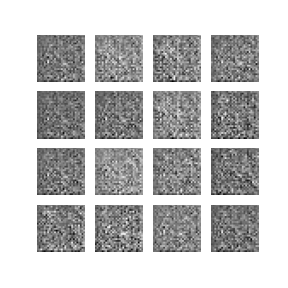

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)


In [ ]:
def plot_latent_images(model, n, digit_size=28):
  """Plots n x n digit images decoded from the latent space."""

  norm = tfp.distributions.Normal(0, 1)
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = model.sample(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()

  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()


In [ ]:
plot_latent_images(model, 20)


ValueError: ignored